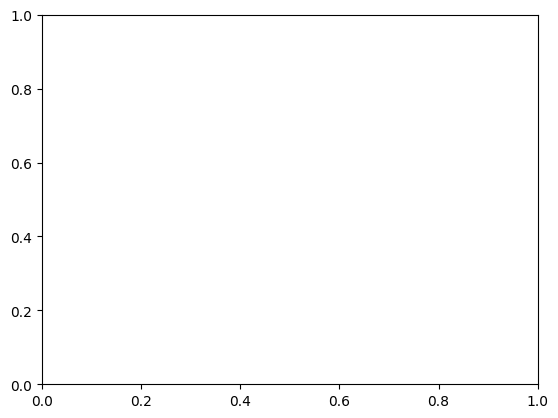

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import gymnasium as gym
from gymnasium import spaces
import matplotlib.colors as mcolors

fig, ax = plt.subplots()

In [2]:
EPISODES = 10_000
MAX_STEPS = 200
COLUMNS = 10
ROWS = 10
ACTION_MAPPINGS = {
    0: (-1, 0),  # Move up
    1: (1, 0),   # Move down
    2: (0, -1),  # Move left
    3: (0, 1)    # Move right
}


In [16]:
class GridEnv(gym.Env):
    def __init__(self):
        super(GridEnv, self).__init__()
        self.action_space = spaces.Discrete(4) # Up, Down, Left, Right
        self.observation_space = spaces.Box(low=np.array([0, 0]), high=np.array([ROWS - 1, COLUMNS - 1]), dtype=np.int32)
        self.reward_map = None
        self.obstacle_position = [np.random.randint(ROWS), np.random.randint(COLUMNS)]
        self.step_counter = 0
        self.total_rewards_collected = 0
        self.reset()

    def reset(self):
        self.state_agent1 = np.array([0, 0])  # Starting position for agent 1
        self.state_agent2 = np.array([ROWS - 1, COLUMNS - 1])  # Starting position for agent 2

        self.initialize_reward_map()
        self.step_counter = 0  # Reset the step counter at the start of each episode
        self.total_rewards_collected = 0
        return self.state_agent1, self.state_agent2

    def initialize_reward_map(self):
        self.reward_map = np.full((ROWS, COLUMNS), 1)
        self.reward_map[self.obstacle_position[0], self.obstacle_position[1]] = -100
        # self.reward_map[self.state[0], self.state[1]] = 100  # Set the starting column to 0
        # self.reward_map[ROWS-1,0] = 100
        # self.reward_map[-1, :] = 100  # Set the bottom row to 100
            
    def reset_reward_map(self):
        self.initialize_reward_map()
        self.reward_map[0,0] = -1  # Mark the starting position

    def step(self, action_agent1, action_agent2):
        # Apply action for agent 1
        new_state_agent1, reward_agent1, done_agent1 = self.apply_action(self.state_agent1, action_agent1)

        # Apply action for agent 2
        new_state_agent2, reward_agent2, done_agent2 = self.apply_action(self.state_agent2, action_agent2)

        # Update states for both agents
        self.state_agent1 = new_state_agent1
        self.state_agent2 = new_state_agent2

        # Update the reward map to reflect movements of both agents
        y1, x1 = self.state_agent1
        y2, x2 = self.state_agent2
        self.reward_map[y1, x1] = -1  # Mark position for agent 1
        self.reward_map[y2, x2] = -1  # Mark position for agent 2

        # Check if either agent is done
        done = done_agent1 or done_agent2

        return (new_state_agent1, new_state_agent2), (reward_agent1, reward_agent2), done, {}

    def apply_action(self, agent, action):
        # Initialize done as False
        done = False
        reward = 0.
        delta = ACTION_MAPPINGS.get(action, (0, 0))
        # Update state based on action with x, y format

        new_state = np.array([agent[0] + delta[0], agent[1] + delta[1]])
        # Check and handle boundary conditions
        if new_state[0] < 0 or new_state[0] >= ROWS or new_state[1] < 0 or new_state[1] >= COLUMNS:
            reward = -100
            done = True
        else:
            # Update the current state and the previous state
            agent = new_state                  # Update the current state to new state

            self.step_counter += 1
            reward += self.calculate_reward(agent)  
            done = self.is_done()

            y = agent[0]
            x = agent[1]
            self.reward_map[y, x] = -1

        return agent, reward, done

            
    def calculate_reward(self, state):
        return self.reward_map[state[0], state[1]]

    def is_done(self):
        # Check if all cells in the grid have been visited or if a step limit is reached
        max_steps = MAX_STEPS  # Example step limit
        count_minus_one = np.sum(self.reward_map == -1)
        count_minus_hundred = np.sum(self.reward_map == -100)
        return count_minus_one == (self.reward_map.size - 1) and count_minus_hundred == 1 or self.step_counter >= max_steps    
        
    # def render(self, mode='human'):
    #     plt.figure(figsize=(5, 5))
    #     plt.imshow(self.reward_map, cmap='viridis', origin='lower')
    #     plt.scatter(self.state[1], self.state[0], c='red', marker='o')  # Agent's position
    #     plt.title("Agent's movement in Grid")
    #     plt.pause(0.1)  # Pause for a short period to create animation effect
        

In [17]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.2, discount_factor=0.9, epsilon=0.1, gasoline_capacity=1000, wheat_capacity=100):
        self.env = env
        self.gasoline = gasoline_capacity  # Initial gasoline level
        self.wheat = 0  # Initial wheat level
        self.gasoline_capacity = gasoline_capacity
        self.wheat_capacity = wheat_capacity

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = np.zeros((ROWS, COLUMNS, env.action_space.n))

    def choose_action(self, prev_state, state, neg_reward):

        def get_new_state(action):
            delta = ACTION_MAPPINGS.get(action, (0, 0))
            return np.array([state[0] + delta[0], state[1] + delta[1]])

        def is_valid_action(action):
            new_state = get_new_state(action)
            return not np.array_equal(new_state, prev_state)
        
        def find_second_best_action(q_values):
            # Copy to avoid modifying the original array
            temp_q_values = np.copy(q_values)

            # Find the index of the best action
            best_action = np.argmax(temp_q_values)

            # Mask the best action by setting its value to negative infinity
            temp_q_values[best_action] = -np.inf

            # Find the second best action
            second_best_action = np.argmax(temp_q_values)

            return second_best_action

        action = None
        state_index = (state[0], state[1])
        if neg_reward > 3:
            # Implement logic to find the nearest positive reward
            action = self.find_nearest_positive_reward_action(state)
        elif np.random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()  # Explore: random action
        else:
            action = np.argmax(self.q_table[state_index])  # Exploit: best known action

        if not is_valid_action(action):
            action = find_second_best_action(self.q_table[state_index])

        # Additional check or fallback strategy if needed
        if not is_valid_action(action):
            # Implement fallback strategy, e.g., select a random action
            action = self.env.action_space.sample()

        return action
    
    def find_nearest_positive_reward_action(self, state):
        min_distance = float('inf')
        best_action = None

        # Search the grid for the nearest positive reward
        for y in range(ROWS):
            for x in range(COLUMNS):
                if self.env.reward_map[y, x] > 0:  # Check for positive reward
                    distance = abs(state[0] - y) + abs(state[1] - x)
                    if distance < min_distance:
                        min_distance = distance
                        best_action = self.determine_action_to_reward(state, (y, x))

        return best_action

    def determine_action_to_reward(self, current_state, reward_state):
        dy = reward_state[0] - current_state[0]
        dx = reward_state[1] - current_state[1]

        if abs(dy) > abs(dx):
            return 1 if dy > 0 else 0  # Move down (1) or up (0) based on the y-difference
        else:
            return 3 if dx > 0 else 2  # Move right (3) or left (2) based on the x-difference
    
    def learn(self, state, action, reward, next_state):
        state_index = (state[0], state[1])
        next_state_index = (next_state[0], next_state[1])
        # Update rule for Q-learning
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.discount_factor * self.q_table[next_state_index][best_next_action]
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.learning_rate * td_error



In [18]:
def train_agent(env, agent1, agent2, episodes):
    best_total_reward_agent1 = -float('inf')
    best_total_reward_agent2 = -float('inf')
    best_path_agent1 = []
    best_path_agent2 = []

    for episode in range(episodes):
        state_agent1, state_agent2 = env.reset()
        prev_state_agent1 = None
        prev_state_agent2 = None
        current_path_agent1 = [state_agent1]
        current_path_agent2 = [state_agent2]
        done = False
        total_reward_agent1 = 0
        total_reward_agent2 = 0
        neg_reward_agent1 = 0
        neg_reward_agent2 = 0

        while not done:
            action_agent1 = agent1.choose_action(prev_state_agent1, state_agent1, neg_reward_agent1)
            action_agent2 = agent2.choose_action(prev_state_agent2, state_agent2, neg_reward_agent2)
            (next_state_agent1, next_state_agent2), (reward_agent1, reward_agent2), done, _ = env.step(action_agent1, action_agent2)
            agent1.learn(state_agent1, action_agent1, reward_agent1, next_state_agent1)
            agent2.learn(state_agent2, action_agent2, reward_agent2, next_state_agent2)
                
            total_reward_agent1 += reward_agent1
            total_reward_agent2 += reward_agent2

            prev_state_agent1 = state_agent1
            prev_state_agent2 = state_agent2

            state_agent1 = next_state_agent1
            state_agent2 = next_state_agent2
            current_path_agent1.append(state_agent1)
            current_path_agent2.append(state_agent2)

            if reward_agent1 < 0:
                neg_reward_agent1 += 1
            else:
                neg_reward_agent1 = 0

            if reward_agent2 < 0:
                neg_reward_agent2 += 1
            else:
                neg_reward_agent2 = 0

        if total_reward_agent1 > best_total_reward_agent1:
            best_total_reward_agent1 = total_reward_agent1
            best_path_agent1 = current_path_agent1

        if total_reward_agent2 > best_total_reward_agent2:
            best_total_reward_agent2 = total_reward_agent2
            best_path_agent2 = current_path_agent2

        if episode % 10 == 0:
            print(f"Episode {episode}: Total Reward Agent 1: {total_reward_agent1}, Agent 2: {total_reward_agent2}")

    return best_path_agent1, best_path_agent2


In [19]:
# Train the agent
env = GridEnv()
agent1 = QLearningAgent(env)
agent2 = QLearningAgent(env)
best_path_agent1, best_path_agent2 = train_agent(env, agent1, agent2, episodes=EPISODES)


Episode 0: Total Reward Agent 1: -100, Agent 2: 1.0
Episode 10: Total Reward Agent 1: 19.0, Agent 2: -82.0
Episode 20: Total Reward Agent 1: 3.0, Agent 2: -98.0
Episode 30: Total Reward Agent 1: -86.0, Agent 2: 25.0
Episode 40: Total Reward Agent 1: 11.0, Agent 2: -90.0
Episode 50: Total Reward Agent 1: 6.0, Agent 2: -95.0


Episode 60: Total Reward Agent 1: 15.0, Agent 2: -82.0
Episode 70: Total Reward Agent 1: 9.0, Agent 2: -92.0
Episode 80: Total Reward Agent 1: 32.0, Agent 2: -188.0
Episode 90: Total Reward Agent 1: -2.0, Agent 2: -2.0
Episode 100: Total Reward Agent 1: 1.0, Agent 2: -100
Episode 110: Total Reward Agent 1: 13.0, Agent 2: -88.0
Episode 120: Total Reward Agent 1: -83.0, Agent 2: 10.0
Episode 130: Total Reward Agent 1: -98.0, Agent 2: 9.0
Episode 140: Total Reward Agent 1: -89.0, Agent 2: 14.0
Episode 150: Total Reward Agent 1: -12.0, Agent 2: -89.0
Episode 160: Total Reward Agent 1: 6.0, Agent 2: -95.0
Episode 170: Total Reward Agent 1: 4.0, Agent 2: -73.0
Episode 180: Total Reward Agent 1: -91.0, Agent 2: 10.0
Episode 190: Total Reward Agent 1: -100, Agent 2: 1.0
Episode 200: Total Reward Agent 1: -84.0, Agent 2: 17.0
Episode 210: Total Reward Agent 1: -90.0, Agent 2: 15.0
Episode 220: Total Reward Agent 1: 0.0, Agent 2: -4.0
Episode 230: Total Reward Agent 1: 6.0, Agent 2: -95.0
Episod

In [20]:
def animation_plot(state_agent1, state_agent2, env, ax):
    # Update the reward map to reflect the agents' movements
    env.reward_map[state_agent1[0], state_agent1[1]] = -1
    env.reward_map[state_agent2[0], state_agent2[1]] = -1

    ax.clear()
    ax.imshow(env.reward_map, cmap=cmap, norm=norm, alpha=0.8)
    ax.scatter(state_agent1[1], state_agent1[0], color='red', label='Agent 1', s=100)
    ax.scatter(state_agent2[1], state_agent2[0], color='blue', label='Agent 2', s=100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()
    
def update(frame, best_path_agent1, best_path_agent2, env, ax):
    if frame < len(best_path_agent1) and frame < len(best_path_agent2):
        state_agent1 = best_path_agent1[frame]
        state_agent2 = best_path_agent2[frame]
        animation_plot(state_agent1, state_agent2, env, ax)
    else:
        update.done = True  # Stop the animation when the end of both paths is reached

colors = ['black', 'green', 'white', 'yellow']  # Replace with actual colors
cmap = mcolors.ListedColormap(colors)

# Define the boundaries for these values
# The values are chosen to ensure that -100, -1, and 1 fall into separate bins
bounds = [-200, -1, 1, 200]
norm = mcolors.BoundaryNorm(bounds, cmap.N)


In [22]:
# Reset the environment and reward map to initial state
env.reset()
env.reset_reward_map()
# Create the animation using the best paths of both agents
animation = FuncAnimation(fig, lambda frame: update(frame, best_path_agent1, best_path_agent2, env, ax),
                          frames=max(len(best_path_agent1), len(best_path_agent2)),
                          interval=100)
# Display the animation in Jupyter Notebook
HTML(animation.to_jshtml())



c:\Users\Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


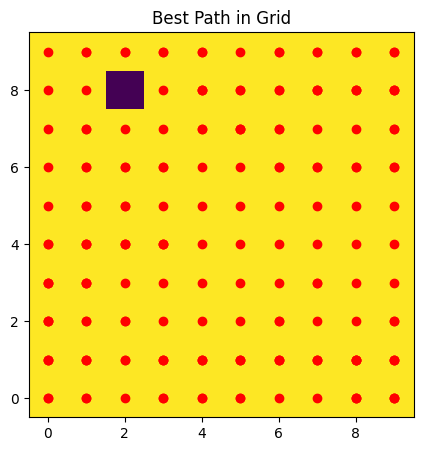

[array([0, 0]), array([1, 0]), array([2, 0]), array([3, 0]), array([3, 1]), array([2, 1]), array([2, 2]), array([1, 2]), array([1, 1]), array([1, 0]), array([2, 0]), array([3, 0]), array([3, 1]), array([3, 2]), array([3, 3]), array([4, 3]), array([4, 2]), array([5, 2]), array([6, 2]), array([7, 2]), array([7, 1]), array([6, 1]), array([5, 1]), array([4, 1]), array([4, 0]), array([5, 0]), array([6, 0]), array([7, 0]), array([8, 0]), array([9, 0]), array([9, 1]), array([9, 2]), array([9, 3]), array([9, 4]), array([9, 5]), array([9, 6]), array([9, 7]), array([9, 8]), array([9, 9]), array([8, 9]), array([8, 8]), array([8, 7]), array([8, 6]), array([9, 6]), array([9, 7]), array([9, 8]), array([9, 9]), array([8, 9]), array([7, 9]), array([6, 9]), array([6, 8]), array([7, 8]), array([8, 8]), array([8, 7]), array([8, 6]), array([7, 6]), array([6, 6]), array([5, 6]), array([4, 6]), array([3, 6]), array([2, 6]), array([1, 6]), array([1, 5]), array([0, 5]), array([0, 6]), array([0, 7]), array([1,

In [151]:
def plot_best_path(env, best_path):
    plt.figure(figsize=(5, 5))
    plt.imshow(env.reward_map, cmap='viridis', origin='lower')

    # Plot the path
    for state in best_path:
        plt.scatter(state[1], state[0], c='red', marker='o')

    plt.title("Best Path in Grid")
    plt.show()
plot_best_path(env, best_path)
print(best_path)

In [152]:
def transform_path(original_path, iteration):
    transformed_path = []
    ROWS = 10  # Assuming the number of rows is constant at 10

    for x, y in original_path:
        if iteration % 2 == 1:
            # For odd iterations, increase x and increment y
            new_x = x
            new_y = y + (iteration - 1)
        else:
            # For even iterations, decrease x and increment y
            new_x = ROWS - 1 - x
            new_y = y + (iteration - 1)
        
        transformed_path.append(np.array([new_x, new_y]))

    # Add the last point of the iteration
    if iteration % 2 == 1:
        transformed_path.append(np.array([ROWS - 1, transformed_path[-1][1] + 1]))
    else:
        transformed_path.append(np.array([0, transformed_path[-1][1] + 1]))

    return transformed_path

for iteration in range(1, 4):
    print(f"Iteration {iteration}: {transform_path(best_path, iteration)}")

Iteration 1: [array([0, 0]), array([1, 0]), array([2, 0]), array([3, 0]), array([3, 1]), array([2, 1]), array([2, 2]), array([1, 2]), array([1, 1]), array([1, 0]), array([2, 0]), array([3, 0]), array([3, 1]), array([3, 2]), array([3, 3]), array([4, 3]), array([4, 2]), array([5, 2]), array([6, 2]), array([7, 2]), array([7, 1]), array([6, 1]), array([5, 1]), array([4, 1]), array([4, 0]), array([5, 0]), array([6, 0]), array([7, 0]), array([8, 0]), array([9, 0]), array([9, 1]), array([9, 2]), array([9, 3]), array([9, 4]), array([9, 5]), array([9, 6]), array([9, 7]), array([9, 8]), array([9, 9]), array([8, 9]), array([8, 8]), array([8, 7]), array([8, 6]), array([9, 6]), array([9, 7]), array([9, 8]), array([9, 9]), array([8, 9]), array([7, 9]), array([6, 9]), array([6, 8]), array([7, 8]), array([8, 8]), array([8, 7]), array([8, 6]), array([7, 6]), array([6, 6]), array([5, 6]), array([4, 6]), array([3, 6]), array([2, 6]), array([1, 6]), array([1, 5]), array([0, 5]), array([0, 6]), array([0, 7

In [153]:
# def plot_q_values(agent):
#     fig, axs = plt.subplots(agent.env.grid_size, agent.env.grid_size, figsize=(20, 20))

#     # Iterate over all grid cells
#     for i in range(agent.env.grid_size):
#         for j in range(agent.env.grid_size):
#             ax = axs[i, j]
#             q_values = agent.q_table[i, j]

#             # Use a bar chart or similar to represent Q-values for each action
#             ax.bar(range(len(q_values)), q_values, color=['blue', 'green', 'red', 'purple'])
#             ax.set_ylim([-100, 100])  # Assuming Q-values are in this range; adjust as needed
#             ax.set_xticks(range(len(q_values)))
#             ax.set_xticklabels(['Up', 'Down', 'Left', 'Right'])
#             ax.set_title(f"State ({i}, {j})")

#     plt.tight_layout()
#     plt.show()

# # Assuming your agent is named 'agent' and has been trained
# plot_q_values(agent)